<a href="https://colab.research.google.com/github/suchitra2020180/RS_GIS_Python/blob/main/Data_visualisation_Python_Part2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Day 8: XArray -Basics, visualisation

Introduction to XArray
XArray Basics
Visualizing Monthly Median Composites with XArray


##Overview
XArray is the package used to work with raster datasets and gridded datasets for weather and climate.

In python to work with raster data we generally use rasterio, rasterio is used to read differnt formats of raster data, but the API of rasterio is not suitable for time series data.
In pandas it is very easy to work with filtering and manipulation of data, but it is difficult with rasterio as it deals with files.

Xarray is an evolution of rasterio and is inspired by libraries like pandas to work with raster datasets.
It supports vectorised operations on arrys resulting in magnitudes of faster processing over other Python/R packages.[benchmark](https://kadyb.github.io/raster-benchmark/report.html).
It supports multiprocessing in cloud.

It is particularly suited for working with multi-dimensional time-series raster datasets. It also integrates tightly with dask that allows one to scale raster data processing using parallel computing. XArray provides [Plotting Functions](https://docs.xarray.dev/en/stable/user-guide/plotting.html) based on Matplotlib.
Fast evolving ecosystem around spatial extensions (rioxarray, xarray-spatial, xy-scipy etc.)



In this section, we will learn about XArray basics and learn how to work with a time-series of Sentinel-2 satellite imagery to create and visualize a median composite image.


##Basic Terminology:
Variables: This is similar to a band in a raster dataset. Each variable contains an array of values.(Ex: satellite has 3 bands-blue,green and red bands, so 3 variables; for climate data-precipitaion and temperature are variables)
Dimensions: This is similar to number of array axes. A grid of pixels (lat and lon) at multiple time intervals time with multiple variables is a 4D dataset (lat,long,time and bands).

A typical dataset has 4 dimensions- X,Y, time, bands in each timestamp.
Coordinates: These are the labels for values in each dimension. We have labels for lat, lon and time.
Attributes: This is the metadata associated with the dataset.

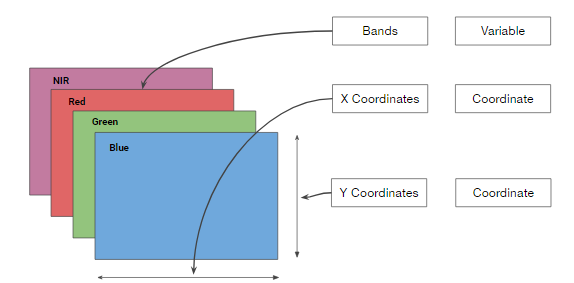

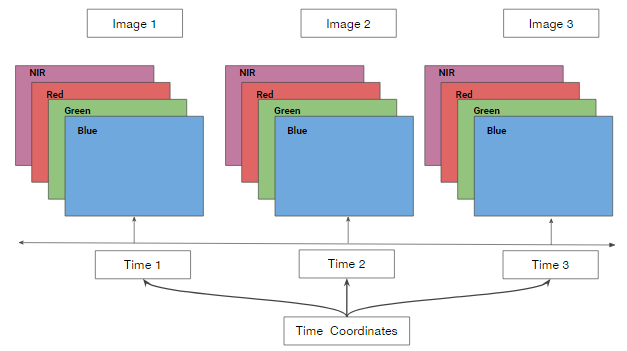

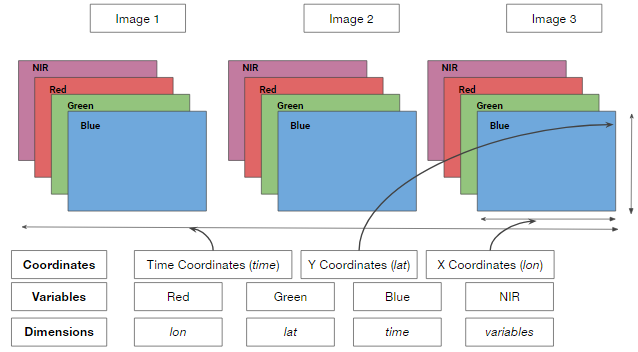


Let's say we have multiple images of a same area over different times. We need blue band from image 2. Then we need to say we need a variable (blue) from time coordinate (time 2).
In rasterio we will all images seperately and work seperately.But in xarray all the images are read in a single variable. This makes all operations easy.



##Xarray Basics
In this section, we will learn about XArray basics and learn how to work with a time-series of Sentinel-2 satellite imagery to create and visualize a median composite image.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install pystac-client odc-stac rioxarray
    !pip install --upgrade dask

In [1]:
!pip install pystac-client odc-stac rioxarray
!pip install --upgrade dask

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.1/150.1 kB 8.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 4.4 MB/s eta 0:00:00
  Attempting uninstall: dask
    Found existing installation: dask 2024.8.2
    Uninstalling dask-2024.8.2:
      Successfully uninstalled dask-2024.8.2


==>The **pystac-client** module is a Python library used for interacting with SpatioTemporal Asset Catalogs (STAC) via STAC APIs. STAC is a standard format for representing geospatial data, which makes it easier to search, discover, and access satellite imagery and other spatial datasets.

The pystac-client library provides a convenient way to search and retrieve metadata about geospatial assets using STAC APIs. It can be used to query STAC-compliant datasets from various data providers, filter search results, and access geospatial data efficiently.


==>The **odc_stack** module is part of the Open Data Cube [(ODC)](https://www.opendatacube.org/) ecosystem, which is an open-source geospatial data management platform. Open Data Cube is widely used for handling and analyzing large-scale Earth observation data from satellites.

In [2]:
import os
import xarray as xr
import rioxarray as rxr
import pystac_client
from odc.stac import stac_load
import matplotlib.pyplot as plt


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import os
main_path="/content/drive/MyDrive/Jobs_Projects_Doc/Spatial_Analysis_Python"
data_folder="data"
output_folder="output"

data_folder_path=os.path.join(main_path,data_folder)
output_folder_path=os.path.join(main_path,output_folder)

if not os.path.exists(data_folder_path):
  os.mkdir(data_folder_path)

if not os.path.exists(output_folder_path):
  os.mkdir(output_folder_path)

##Get Satellite Imagery using STAC API

We define a location and time of interest to get some satellite imagery.

In [6]:
latitude = 27.163
longitude = 82.608
year = 2023

Let’s use [Element8](https://www.element84.com/earth-search/) search endpoint to look for items from the sentinel-2-l2a collection on AWS and access it using pystac_client


In [12]:
#Define a bounding box
km2deg=1.0/111
x,y=(longitude,latitude)
r=1*km2deg
#Create bounding box for that point
bbox=(x-r,y-r,x+r,y+r)

#Access satellite data through Amazon STAC API using pystac_client module for the gievn lat,long.
aws_catalog = pystac_client.Client.open('https://earth-search.aws.element84.com/v1')
search = aws_catalog.search(
    collections=['sentinel-2-c1-l2a'],
    bbox=bbox,
    datetime=f'{year}',
    query={'eo:cloud_cover':{'lt':30}},
)

items=search.item_collection()
print('AWS Catalog:',aws_catalog)
print('Search:',search)
print('Items:',items)

AWS Catalog: <Client id=earth-search-aws>
Search: <pystac_client.item_search.ItemSearch object at 0x7f1e4eefa7a0>
Items: <pystac.item_collection.ItemCollection object at 0x7f1e4eefb010>


## After accessing data from STAC API, the items should be read using **stac_load**
Load the matching images as a XArray Dataset.

In [14]:
ds = stac_load(
    items,
    bands=['red','green','blue','nir'],
    resolution=10,
    bbox=bbox,
    chunks={}, #for Dask
    groupby='solar_day',
    )

ds

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    green        (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    blue         (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    nir          (time, y, x) uint16 5MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>

In [15]:
ds.compute()

<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB 7592 7548 7388 7236 ... 2038 2198 2240
    green        (time, y, x) uint16 5MB 7308 7260 7188 7064 ... 2204 2192 2188
    blue         (time, y, x) uint16 5MB 7332 7152 7112 7036 ... 1947 2010 2040
    nir          (time, y, x) uint16 5MB 8076 7996 7840 7708 ... 3978 3708 3352

In [16]:
%%time

UsageError: %%time is a cell magic, but the cell body is empty. Did you mean the line magic %time (single %)?


In [18]:
%%time
ds.compute()

CPU times: user 12.6 s, sys: 25.1 s, total: 37.6 s
Wall time: 1min 18s


<xarray.Dataset> Size: 21MB
Dimensions:      (y: 202, x: 182, time: 70)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Data variables:
    red          (time, y, x) uint16 5MB 7592 7548 7388 7236 ... 2038 2198 2240
    green        (time, y, x) uint16 5MB 7308 7260 7188 7064 ... 2204 2192 2188
    blue         (time, y, x) uint16 5MB 7332 7152 7112 7036 ... 1947 2010 2040
    nir          (time, y, x) uint16 5MB 8076 7996 7840 7708 ... 3978 3708 3352

In [17]:
%time

CPU times: user 3 µs, sys: 3 µs, total: 6 µs
Wall time: 10.3 µs


## XArray Terminology

We now have a `xarray.Dataset` object. Let's understand what is contained in a Dataset.

* *Variables*: This is similar to a band in a raster dataset. Each variable contains an array of values.
* *Dimensions*: This is similar to number of array axes.
* *Coordinates*: These are the labels for values in each dimension.
* *Attributes*: This is the metadata associated with the dataset.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/xarray_terminology.png' width=800/>

A Dataset consists of one or more **xarray.DataArray object**. This is the main object that consists of a single variable with dimension names, coordinates and attributes. You can access each variable using dataset.variable_name syntax.

In [19]:
da=ds.red
da

<xarray.DataArray 'red' (time: 70, y: 202, x: 182)> Size: 5MB
dask.array<red, shape=(70, 202, 182), dtype=uint16, chunksize=(1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...
Attributes:
    nodata:   0

##Selecting Data
XArray provides a very powerful way to select subsets of data, using similar framework as Pandas. Similar to Panda's loc and iloc methods, XArray provides sel and isel methods. Since DataArray dimensions have names, these methods allow you to specify which dimension to query.

Let's select the temperature anomany values for the last time step. Since we know the index (-1) of the datam we can use isel method.

In [20]:
da.isel(time=-1)

<xarray.DataArray 'red' (y: 202, x: 182)> Size: 74kB
dask.array<getitem, shape=(202, 182), dtype=uint16, chunksize=(202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-12-26T05:11:10.219000
Attributes:
    nodata:   0

You can call .values on a DataArray to get an array of the values.

In [21]:
da.isel(time=-1).values

array([[   0,    0,    0, ..., 1821, 1762, 1830],
       [   0,    0,    0, ..., 1818, 1750, 1814],
       [   0,    0,    0, ..., 1776, 1816, 1832],
       ...,
       [2078, 2092, 2058, ..., 1899, 2152, 2302],
       [2080, 2084, 2090, ..., 1936, 2188, 2290],
       [1970, 2030, 2034, ..., 2038, 2198, 2240]], dtype=uint16)

In [24]:
da.isel(time=-1, x=-1, y=-1)

<xarray.DataArray 'red' ()> Size: 2B
dask.array<getitem, shape=(), dtype=uint16, chunksize=(), chunktype=numpy.ndarray>
Coordinates:
    y            float64 8B 3.005e+06
    x            float64 8B 6.602e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-12-26T05:11:10.219000
Attributes:
    nodata:   0

You can query for a values at using multiple dimensions.

In [22]:
da.isel(time=-1, x=-1, y=-1).values

array(2240, dtype=uint16)

We can also specify a value to query using the sel() method.

Let's see what are the values of time variable.

In [26]:
da.time

<xarray.DataArray 'time' (time: 70)> Size: 560B
array(['2023-01-13T05:21:06.880000000', '2023-01-18T05:21:06.614000000',
       '2023-01-23T05:21:05.552000000', '2023-02-07T05:21:07.419000000',
       '2023-02-09T05:11:12.073000000', '2023-02-12T05:21:07.542000000',
       '2023-02-14T05:11:11.668000000', '2023-02-19T05:11:10.303000000',
       '2023-02-22T05:21:06.867000000', '2023-03-01T05:11:10.619000000',
       '2023-03-04T05:21:06.040000000', '2023-03-06T05:11:16.188000000',
       '2023-03-09T05:21:13.261000000', '2023-03-11T05:11:08.720000000',
       '2023-03-24T05:21:07.945000000', '2023-03-26T05:11:16.033000000',
       '2023-04-03T05:21:08.616000000', '2023-04-05T05:11:16.355000000',
       '2023-04-08T05:21:11.786000000', '2023-04-10T05:11:13.434000000',
       '2023-04-13T05:21:09.401000000', '2023-04-18T05:21:11.018000000',
       '2023-04-23T05:21:08.563000000', '2023-04-25T05:11:15.158000000',
       '2023-05-05T05:11:15.867000000', '2023-05-10T05:11:12.717000000',
       '2023-05-13T05:21:09.142000000', '2023-05-18T05:21:14.056000000',
       '2023-05-20T05:11:15.658000000', '2023-05-28T05:21:13.828000000',
       '2023-05-30T05:11:17.093000000', '2023-06-02T05:21:13.236000000',
       '2023-06-04T05:11:17.494000000', '2023-06-07T05:21:14.094000000',
       '2023-06-09T05:11:16.986000000', '2023-06-12T05:21:13.428000000',
       '2023-06-14T05:11:18.288000000', '2023-06-17T05:21:14.149000000',
       '2023-06-19T05:11:17.345000000', '2023-06-22T05:21:13.013000000',
       '2023-07-22T05:21:13.598000000', '2023-08-28T05:11:19.006000000',
       '2023-09-30T05:21:11.559000000', '2023-10-10T05:21:08.417000000',
       '2023-10-12T05:11:15.242000000', '2023-10-15T05:21:11.673000000',
       '2023-10-20T05:21:09.168000000', '2023-10-22T05:11:14.930000000',
       '2023-10-25T05:21:10.189000000', '2023-10-27T05:11:13.227000000',
       '2023-10-30T05:21:08.875000000', '2023-11-01T05:11:15.740000000',
       '2023-11-04T05:21:12.121000000', '2023-11-06T05:11:12.695000000',
       '2023-11-09T05:21:08.806000000', '2023-11-14T05:21:09.587000000',
       '2023-11-16T05:11:11.658000000', '2023-11-19T05:21:06.701000000',
       '2023-11-21T05:11:09.709000000', '2023-11-24T05:21:04.450000000',
       '2023-11-26T05:11:07.426000000', '2023-11-29T05:21:01.463000000',
       '2023-12-01T05:11:10.337000000', '2023-12-06T05:11:06.903000000',
       '2023-12-09T05:21:03.902000000', '2023-12-11T05:11:10.078000000',
       '2023-12-14T05:21:07.692000000', '2023-12-16T05:11:09.255000000',
       '2023-12-24T05:21:10.640000000', '2023-12-26T05:11:10.219000000'],
      dtype='datetime64[ns]')
Coordinates:
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 560B 2023-01-13T05:21:06.880000 ... 20...

In [23]:
dates = da.time.values
dates

array(['2023-01-13T05:21:06.880000000', '2023-01-18T05:21:06.614000000',
       '2023-01-23T05:21:05.552000000', '2023-02-07T05:21:07.419000000',
       '2023-02-09T05:11:12.073000000', '2023-02-12T05:21:07.542000000',
       '2023-02-14T05:11:11.668000000', '2023-02-19T05:11:10.303000000',
       '2023-02-22T05:21:06.867000000', '2023-03-01T05:11:10.619000000',
       '2023-03-04T05:21:06.040000000', '2023-03-06T05:11:16.188000000',
       '2023-03-09T05:21:13.261000000', '2023-03-11T05:11:08.720000000',
       '2023-03-24T05:21:07.945000000', '2023-03-26T05:11:16.033000000',
       '2023-04-03T05:21:08.616000000', '2023-04-05T05:11:16.355000000',
       '2023-04-08T05:21:11.786000000', '2023-04-10T05:11:13.434000000',
       '2023-04-13T05:21:09.401000000', '2023-04-18T05:21:11.018000000',
       '2023-04-23T05:21:08.563000000', '2023-04-25T05:11:15.158000000',
       '2023-05-05T05:11:15.867000000', '2023-05-10T05:11:12.717000000',
       '2023-05-13T05:21:09.142000000', '2023-05-18

We can query using the value of a coordinate using the sel() method.

In [25]:
da.sel(time='2023-12-16')

<xarray.DataArray 'red' (time: 1, y: 202, x: 182)> Size: 74kB
dask.array<getitem, shape=(1, 202, 182), dtype=uint16, chunksize=(1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 8B 2023-12-16T05:11:09.255000
Attributes:
    nodata:   0

The sel() method also support nearest neighbor lookups. This is useful when you do not know the exact label of the dimension, but want to find the closest one.

Tip: You can use interp() instead of sel() to interpolate the value instead of closest lookup.

In [27]:
da.sel(time='2023-01-01', method='nearest')

<xarray.DataArray 'red' (y: 202, x: 182)> Size: 74kB
dask.array<getitem, shape=(202, 182), dtype=uint16, chunksize=(202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
    time         datetime64[ns] 8B 2023-01-13T05:21:06.880000
Attributes:
    nodata:   0

The sel() method also allows specifying range of values using Python's built-in slice() function. The code below will select all observations during January 2023.

In [28]:
da.sel(time=slice('2023-01-01', '2023-01-31'))

<xarray.DataArray 'red' (time: 3, y: 202, x: 182)> Size: 221kB
dask.array<getitem, shape=(3, 202, 182), dtype=uint16, chunksize=(1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * time         (time) datetime64[ns] 24B 2023-01-13T05:21:06.880000 ... 202...
Attributes:
    nodata:   0

#Aggregating Data
A very-powerful feature of XArray is the ability to easily aggregate data across dimensions - making it ideal for many remote sensing analysis. Let's create a median composite from all the individual images.

We apply the .median() aggregation across the time dimension.

In [43]:
median = ds.median(dim='time')
median

<xarray.Dataset> Size: 1MB
Dimensions:      (y: 202, x: 182)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
Data variables:
    red          (y, x) float64 294kB dask.array<chunksize=(202, 182), meta=np.ndarray>
    green        (y, x) float64 294kB dask.array<chunksize=(202, 182), meta=np.ndarray>
    blue         (y, x) float64 294kB dask.array<chunksize=(202, 182), meta=np.ndarray>
    nir          (y, x) float64 294kB dask.array<chunksize=(202, 182), meta=np.ndarray>

##Visualizing Data
XArray provides a plot.imshow() method based on Matplotlib to plot DataArrays.

Reference : [xarray.plot.imshow](https://docs.xarray.dev/en/stable/generated/xarray.plot.imshow.html)

To visualize our Dataset, we first convert it to a DataArray using the to_array() method. All the variables will be converted to a new dimension. Since our variables are image bands, we give the name of the new dimesion as band.

In [46]:
median_da=median.to_array('band')
median_da

<xarray.DataArray (band: 4, y: 202, x: 182)> Size: 1MB
dask.array<stack, shape=(4, 202, 182), dtype=float64, chunksize=(1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * band         (band) object 32B 'red' 'green' 'blue' 'nir'

The easy way to visualize the data without the outliers is to pass the parameter robust=True. This will use the 2nd and 98th percentiles of the data to compute the color limits.

median=ds.median(dim='time')

median_da=median.to_array('band')

median_da.sel(band=['red','green','blue'])

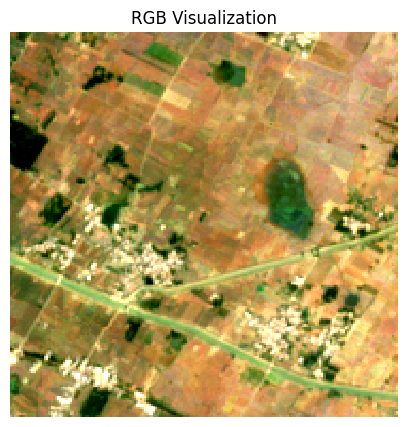

In [48]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
median_da.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    robust=True)#If we dont knoow the min,max values then use robust=True
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

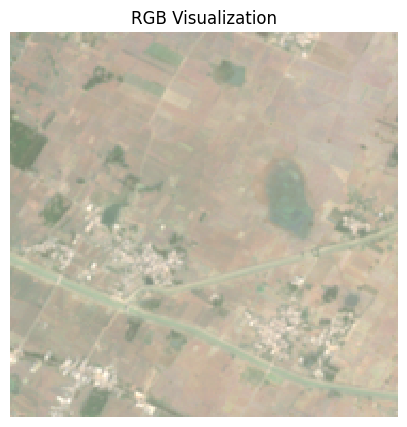

In [49]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
median_da.sel(band=['red', 'green', 'blue']).plot.imshow(
    ax=ax,
    vmin=0, vmax=3000)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

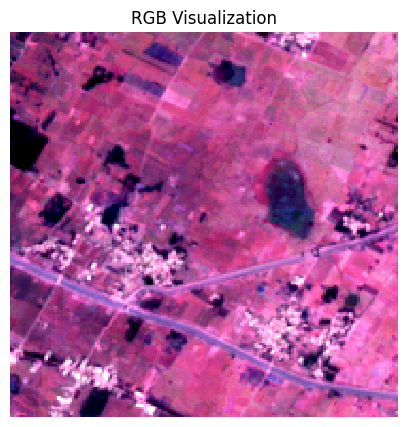

In [51]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5)
median_da.sel(band=['red', 'blue','green']).plot.imshow(
    ax=ax,
    robust=True)
ax.set_title('RGB Visualization')
ax.set_axis_off()
plt.show()

##Exercise
Display the median composite for the month of May.

The snippet below takes our time-series and aggregate it to a monthly median composites groupby() method.

In [52]:
monthly_data=ds.groupby('time.month')
#Median composite of May
monthly=monthly_data.median(dim='time')
monthly

<xarray.Dataset> Size: 14MB
Dimensions:      (month: 12, y: 202, x: 182)
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    red          (month, y, x) float64 4MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    green        (month, y, x) float64 4MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    blue         (month, y, x) float64 4MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>
    nir          (month, y, x) float64 4MB dask.array<chunksize=(1, 202, 182), meta=np.ndarray>

You now have a new dimension named month. Start your exercise by first converting the Dataset to a DataArray. Then extract the data for the chosen month using sel() method and plot it.

In [54]:
month_da=monthly.to_array('band')
month_da

<xarray.DataArray (band: 4, month: 12, y: 202, x: 182)> Size: 14MB
dask.array<stack, shape=(4, 12, 202, 182), dtype=float64, chunksize=(1, 1, 202, 182), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 2kB 3.007e+06 3.007e+06 ... 3.005e+06 3.005e+06
  * x            (x) float64 1kB 6.584e+05 6.584e+05 ... 6.602e+05 6.602e+05
    spatial_ref  int32 4B 32644
  * month        (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
  * band         (band) object 32B 'red' 'green' 'blue' 'nir'

##Visualising image for the month of May

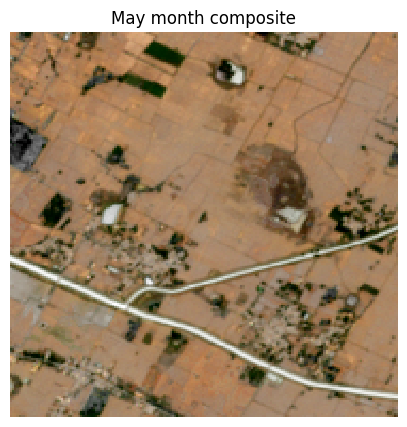

In [55]:
fig,ax=plt.subplots(1,1)
fig.set_size_inches(5,5)
may_composite=month_da.sel(month=5)
may_composite.plot.imshow(ax=ax,robust=True)
ax.set_title('May month composite')
ax.set_axis_off()
plt.show()

##Visualizing Monthly Composites
This notebook shows how to aggregate a time-series of satellite imagery to monthly median composites and visualize them in a grid.

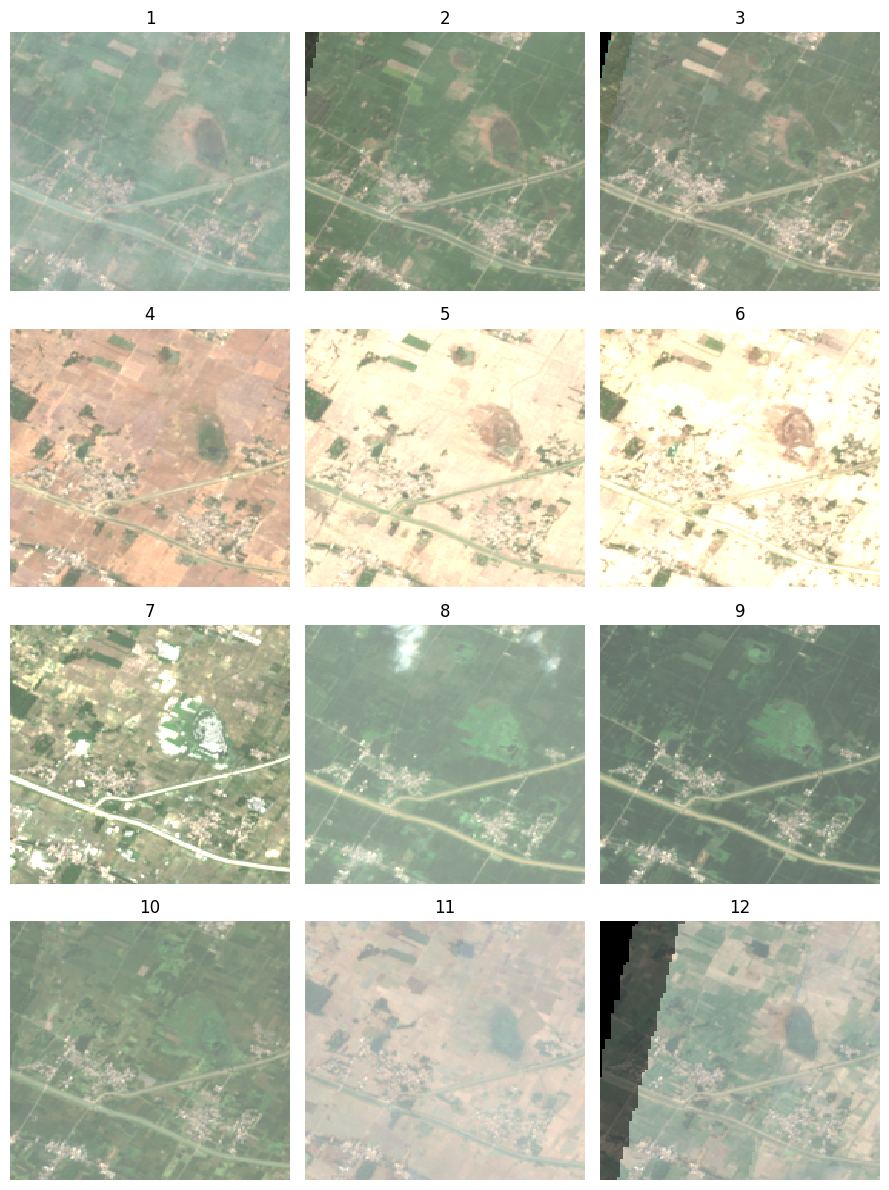

In [58]:
fig, axes = plt.subplots(4, 3)
fig.set_size_inches(9, 12)
for index, ax in enumerate(axes.flat):
    monthly_da = month_da.isel(month=index)
    monthly_da.sel(band=['red', 'green', 'blue']).plot.imshow(
      ax=ax,
      vmin=0,
      vmax=3000)
    ax.set_title(f'{monthly_da.month.values}')
    ax.set_axis_off()
plt.tight_layout()
plt.show()